# FieldTwin API - Python example plotting connection profile

This python notebook provides an example demo of using the FieldTwin API.   
See the API documentation (https://api.fieldtwin.com/).

The example creates an input form to enter the FieldTwin project and subproject     
and loads the subproject data using the FieldTwin API.

A connection can then be selected from the subproject connections       
and its connection profile is plotted.

</br>

---
The code below creates a form to input the FieldTwin API URL, the project id and subproject id.   
The demo requires an API access token to be entered.

In [19]:
#@title Create User Inputs
import ipywidgets as widgets
from IPython.display import display
import requests
import json

# Create the user interface

# API URL input
api_url = 'https://backend.qa.fieldtwin.com/API/v1.9/'
api_url_input = widgets.Text(
  description = 'API:',
  layout = widgets.Layout(width='25rem'),
  value = api_url,
  placeholder = api_url,
)

# API Token input
token_input = widgets.Password(
  description = 'Token',
  value = '',
  placeholder = 'Enter API Token',
)

# Project Id input
project_id = '-M-HHqMifhz6qskW2goc'
project_id_input = widgets.Text(
  value = project_id,
  placeholder = project_id,
  description='Project:',
)

# Subproject Id input
subproject_id = '-M-HI0DPuadaK9GLCWzR'
subproject_id_input = widgets.Text(
  description = 'SubProject:',
  value = subproject_id,
  placeholder = subproject_id,
)

# Load subproject button
subproject_button = widgets.Button(
  description = 'Load SubProject', 
  button_style='info'
)

# create connection dropdown menu
connection_select = widgets.Dropdown()

# create the button to plot the connection profile
connection_button = widgets.Button(
  description = 'Display Profile', 
  button_style='info'
)

# Display the input form
print('Enter the FieldTwin project settings\n')
display(
  api_url_input, 
  token_input, 
  project_id_input, 
  subproject_id_input, 
)

Enter the FieldTwin project settings



Text(value='https://backend.qa.fieldtwin.com/API/v1.9/', description='API:', layout=Layout(width='25rem'), pla…

Password(description='Token', placeholder='Enter API Token')

Text(value='-M-HHqMifhz6qskW2goc', description='Project:', placeholder='-M-HHqMifhz6qskW2goc')

Text(value='-M-HI0DPuadaK9GLCWzR', description='SubProject:', placeholder='-M-HI0DPuadaK9GLCWzR')

The code below sends an API GET request to load the subproject data.

In [20]:
#@title Load the subproject

# The FieldTwin subproject data
subproject = {}
connections = []
connection_list = []

# configure the subproject button action
display(subproject_button)
@subproject_button.on_click
def on_subproject_click(b):
  global subproject 
  global connections
  global connection_list

  # set up the API request
  api_url = api_url_input.value
  api_token = token_input.value
  project_id = project_id_input.value
  subproject_id = subproject_id_input.value

  if api_token == '':
    print('API access token must be entered')
    return

  # retrieve the subproject data using the FieldTwin API
  print('\nLoading ...\n')

  response = requests.get(
    f'{api_url}{project_id}/subProject/{subproject_id}',
    headers={
      'token': api_token,
      # request the connection is sampled every 1 unit
      'sample-every': '1',
      # set the sample method to simplify to significantly reduce the sampled data size
      'simplify': 'true',
    }
  )

  # check for any API fialures
  if (response.status_code != requests.codes.ok):
    print('API request failed: ', response.status_code)
    return

  # request is successful, read the subproject data
  subproject = response.json()

  print(f"Loaded subproject: {subproject['name']}")

  # get list of connections from the loaded subproject data
  if 'connections' in subproject:
    connections = subproject['connections']

    # extract a list of connections
    connection_list = []
    for connection_id in connections:
      connection = connections[connection_id]
      item = {
        'name': connection['params']['label'], 
        'id': connection_id
      }
      connection_list.append(item)

      # populate the connection selection menu
      connection_select.options = [item['name'] for item in connection_list]

  return


Button(button_style='info', description='Load SubProject', style=ButtonStyle())


Loading ...

Loaded subproject: Subproject 1 - Base Case


The code below displays the connection selection menu and provides a button.   
to generate the connection profile plot.

Select connection


Dropdown(options=(), value=None)

Button(button_style='info', description='Display Profile', style=ButtonStyle())

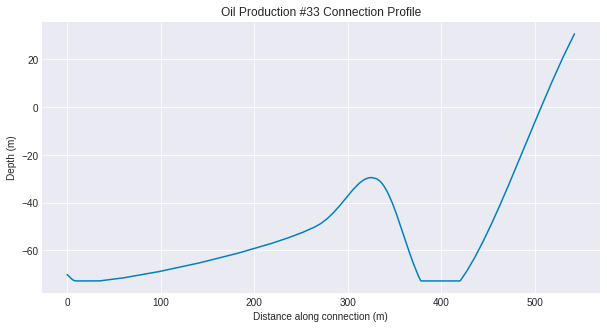

In [21]:
#@title Plot connection profile
import math
import matplotlib.pyplot as plotter
from matplotlib.pyplot import figure

# display the connection selection UI
print('Select connection')
display(connection_select, connection_button)

@connection_button.on_click
def on_connection_click(b):
  global connections
  global connection_list

  if len(connection_list) > 0:
    # obtain the id of the selected connection
    item = connection_list[connection_select.index]
    connection_id = item['id']

    # get the selected connection data
    connection_data = connections[connection_id]

    # obtain the connection coordinate points
    points = []
    points.append(connection_data['fromCoordinate'])

    if 'sampled' in connection_data:
      # use the sampled connection data if it is available
      points = connection_data['sampled']
    elif 'intermediaryPoints' in connection_data:
      # otherwise use the intermediary points
      points = connection_data['intermediaryPoints']
      points.append(connection_data['toCoordinate'])

    # print(points)

    # calculate the distance vs depth profile for the connection
    profile_distance = []
    profile_depth = []
    distance = 0
    x0 = points[0]['x']
    y0 = points[0]['y']
    for point in points:
      x1 = point['x']
      y1 = point['y']
      z = point['z']
      # accumulate the along connection distance
      distance += math.hypot((x1-x0), (y1-y0))
      x0 = x1
      y0 = y1
      profile_distance.append(distance)
      profile_depth.append(z)

    # Plot the profile
    print()
    unit = subproject['coordinateUnits']
    # set the plot styling and size
    plotter.style.use('seaborn-darkgrid')
    plotter.figure(figsize=(10,5))
    # plot the profile
    plotter.plot(profile_distance, profile_depth, c = '#0080C0')
    # set the plot title and axes labels
    plotter.title(f"{item['name']} Connection Profile")
    plotter.xlabel(f'Distance along connection ({unit})')
    plotter.ylabel(f'Depth ({unit})')